# TESS Atlas fit for TOI 143

**Version: 0.1.0**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 143.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-143.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-143.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.0/toi-143.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 143

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 143 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

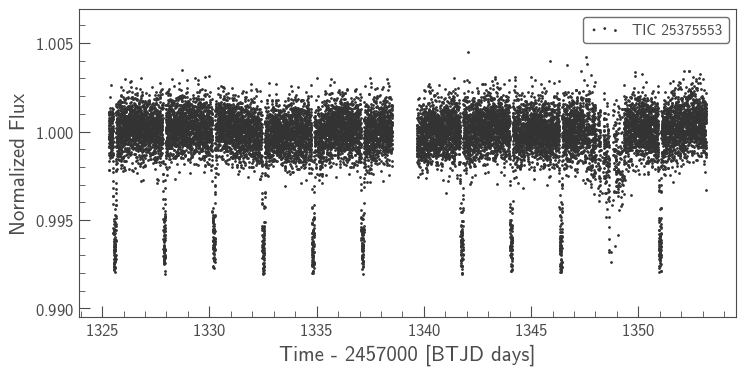

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all()
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")

# tpf_collection[0].to_lightcurve(aperture_mask="pipeline").plot()
# assert 0
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])    
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
lc = lc.remove_outliers()
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] *= 1000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -39741.11811966635 -> -39572.29855521935


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -26028.45866026936 -> -24873.34119794036


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -24873.341197940357 -> -24407.360656608358


optimizing logp for variables: ['logg_star']


message: Desired error not necessarily achieved due to precision loss.
logp: -24407.360656608358 -> -24407.333712046227


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -24407.333712046227 -> -24405.884454366158


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -24405.884454366158 -> -24405.861211444546


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -24405.861211444546 -> -24336.284114692786


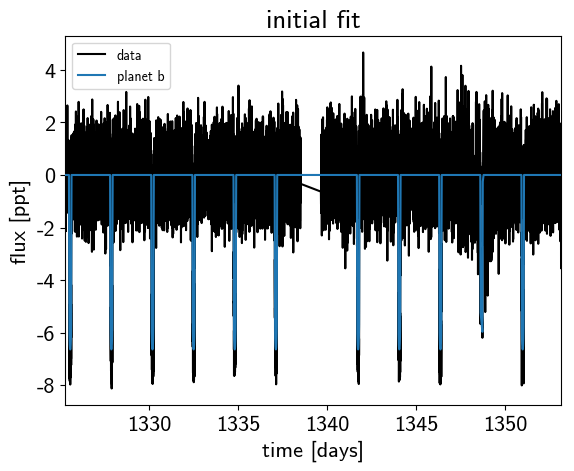

In [7]:
model = build_model(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:04, 18.80draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:10,  8.55draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:01<00:14,  6.13draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:16,  5.21draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:02<00:18,  4.67draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:18,  4.40draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:03<00:19,  4.24draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:19,  4.11draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:04<00:19,  4.03draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:05<00:18,  3.98draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:05<00:18,  3.94draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:06<00:18,  3.89draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:06<00:17,  3.88draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:07<00:17,  3.73draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:07<00:17,  3.71draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:08<00:17,  3.65draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:09<00:16,  3.64draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:09<00:16,  3.67draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:10<00:15,  3.67draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:10<00:13,  3.99draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:11<00:13,  3.92draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:11<00:09,  5.07draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:11<00:13,  3.70draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:12<00:10,  4.40draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:12<00:13,  3.55draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:12<00:10,  4.22draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:13<00:13,  3.31draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:13<00:12,  3.39draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:14<00:11,  3.50draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:14<00:09,  4.33draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:14<00:08,  4.26draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:15<00:08,  4.02draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:15<00:06,  5.27draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:15<00:09,  3.52draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:16<00:08,  3.56draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:16<00:08,  3.56draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:17<00:07,  3.63draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:18<00:06,  3.59draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:18<00:06,  3.60draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:19<00:05,  3.65draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:19<00:05,  3.68draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:19<00:03,  4.85draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:20<00:04,  3.63draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:20<00:03,  4.13draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:20<00:04,  3.48draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:20<00:03,  3.80draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:21<00:03,  3.42draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:21<00:03,  3.58draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:21<00:02,  3.36draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:22<00:02,  3.22draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:22<00:02,  3.58draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:22<00:02,  3.09draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:23<00:01,  3.71draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:23<00:01,  2.99draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:24<00:00,  3.03draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:24<00:00,  2.42draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:25<00:00,  1.55draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:27<00:00,  1.22draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:05, 18.27draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:10,  8.48draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:01<00:15,  5.87draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:17,  4.86draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:02<00:17,  4.90draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:03<00:18,  4.37draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:04<00:19,  4.04draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:04<00:20,  3.80draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:05<00:18,  4.07draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:05<00:18,  3.91draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:05<00:16,  4.49draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:06<00:19,  3.60draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:06<00:18,  3.78draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:06<00:19,  3.61draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:07<00:21,  3.18draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:07<00:16,  4.07draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:07<00:15,  4.27draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:08<00:14,  4.31draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:08<00:16,  3.72draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:08<00:16,  3.64draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:09<00:17,  3.48draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:09<00:16,  3.62draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:09<00:17,  3.27draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:09<00:15,  3.58draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:10<00:14,  3.87draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:10<00:12,  4.26draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:10<00:14,  3.60draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:11<00:13,  3.80draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:11<00:11,  4.22draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:11<00:11,  4.15draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:12<00:13,  3.68draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:12<00:13,  3.54draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:12<00:12,  3.55draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:13<00:13,  3.26draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:13<00:12,  3.39draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:13<00:13,  3.11draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:13<00:10,  3.96draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:14<00:09,  4.26draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:14<00:08,  4.37draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:14<00:09,  3.79draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:15<00:09,  3.92draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:15<00:09,  3.60draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:15<00:08,  3.80draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:15<00:09,  3.64draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:16<00:08,  3.75draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:16<00:08,  3.58draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:16<00:08,  3.65draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:17<00:08,  3.33draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:17<00:06,  4.02draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:17<00:06,  3.75draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:17<00:06,  3.61draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:18<00:07,  3.35draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:18<00:06,  3.70draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:18<00:06,  3.42draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:19<00:05,  3.81draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:19<00:05,  3.56draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:19<00:05,  3.65draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:19<00:05,  3.60draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:20<00:03,  4.12draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:20<00:03,  3.97draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:20<00:04,  3.20draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:21<00:03,  4.00draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:21<00:03,  3.17draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:21<00:02,  3.98draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:22<00:03,  3.03draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:22<00:02,  3.78draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:22<00:02,  2.84draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:23<00:02,  2.89draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:24<00:02,  2.42draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:24<00:01,  2.64draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:24<00:01,  2.36draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:25<00:00,  2.67draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:25<00:00,  2.88draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:27<00:00,  1.15draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<02:09,  1.57draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<01:33,  2.16draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:01<01:22,  2.44draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:01<01:00,  3.26draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:01<00:59,  3.29draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:01<00:45,  4.28draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:02<00:37,  5.14draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:02<00:56,  3.40draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:02<00:56,  3.39draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:03<00:51,  3.69draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:03<00:41,  4.54draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:03<01:03,  2.96draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:04<01:01,  3.02draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:04<00:48,  3.76draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:05<00:57,  3.21draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:05<00:51,  3.53draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:05<00:38,  4.67draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:05<00:31,  5.54draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:06<00:32,  5.48draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:06<00:40,  4.27draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:06<00:35,  4.88draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:07<00:45,  3.79draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:07<00:42,  4.02draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:07<00:39,  4.26draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:08<00:45,  3.68draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:08<00:49,  3.34draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:08<00:48,  3.43draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:09<00:40,  4.04draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:09<00:40,  4.00draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:09<00:36,  4.42draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:09<00:31,  5.11draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:09<00:25,  6.16draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:10<00:42,  3.72draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:10<00:37,  4.15draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:10<00:42,  3.61draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:11<00:40,  3.83draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:11<00:42,  3.57draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:12<00:38,  3.87draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:13<00:35,  4.11draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:13<00:38,  3.72draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:14<00:39,  3.60draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:14<00:34,  4.13draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:15<00:45,  3.05draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:15<00:45,  3.05draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:16<00:39,  3.44draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:16<00:32,  4.10draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:17<00:35,  3.68draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:17<00:37,  3.49draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:17<00:33,  3.89draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:17<00:28,  4.57draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:18<00:42,  2.98draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:18<00:32,  3.83draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:19<00:38,  3.21draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:19<00:40,  3.05draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:19<00:39,  3.11draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:20<00:37,  3.21draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:20<00:39,  3.06draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:20<00:31,  3.70draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:20<00:23,  4.84draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:21<00:22,  5.07draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:21<00:23,  4.78draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:21<00:24,  4.58draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:22<00:27,  4.06draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:22<00:26,  4.05draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:22<00:21,  4.92draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:23<00:29,  3.56draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:23<00:29,  3.50draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:23<00:27,  3.83draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:23<00:20,  5.05draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:24<00:30,  3.35draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:24<00:27,  3.67draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:24<00:32,  3.00draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:25<00:27,  3.61draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:25<00:37,  2.57draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:26<00:35,  2.68draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:26<00:30,  3.09draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:27<00:27,  3.37draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:27<00:23,  3.81draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:27<00:26,  3.34draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:27<00:23,  3.78draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:28<00:26,  3.34draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:28<00:25,  3.32draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:29<00:29,  2.91draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:29<00:23,  3.56draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:29<00:23,  3.56draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:30<00:22,  3.62draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:30<00:21,  3.67draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:31<00:16,  4.60draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:31<00:19,  3.89draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:31<00:17,  4.35draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:31<00:17,  4.20draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:32<00:17,  4.10draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:32<00:14,  4.97draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:32<00:13,  4.94draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:32<00:11,  5.59draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:33<00:16,  4.12draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:33<00:13,  4.80draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:33<00:16,  3.82draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:33<00:13,  4.61draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:34<00:13,  4.37draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:34<00:10,  5.54draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:35<00:13,  4.22draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:35<00:10,  5.33draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:35<00:13,  3.95draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:35<00:10,  5.17draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:36<00:09,  5.26draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:36<00:08,  5.64draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:36<00:11,  4.24draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:36<00:09,  4.85draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:37<00:10,  4.30draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:37<00:07,  5.45draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:37<00:10,  3.95draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:37<00:07,  5.27draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:38<00:07,  4.85draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:38<00:09,  3.84draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:39<00:08,  4.25draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:39<00:09,  3.50draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:39<00:07,  4.20draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:39<00:05,  5.63draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:40<00:05,  4.71draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:40<00:08,  3.28draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:41<00:06,  4.07draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [00:41<00:06,  3.54draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:41<00:05,  3.92draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:41<00:04,  4.75draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:42<00:04,  4.47draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:42<00:03,  5.65draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:43<00:03,  4.61draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:43<00:03,  4.17draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:44<00:02,  4.46draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:44<00:02,  4.62draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:44<00:02,  3.48draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:44<00:02,  4.00draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:45<00:01,  5.18draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:45<00:00,  4.40draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:46<00:01,  2.94draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:46<00:00,  3.87draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:47<00:00,  1.80draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 3/404 [00:00<00:14, 27.62draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:14, 26.95draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:00<00:15, 25.66draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:00<00:13, 29.63draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:00<00:11, 32.63draws/s]

Sampling 2 chains:   6%|▋         | 26/404 [00:00<00:09, 38.49draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:00<00:09, 37.74draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:00<00:10, 36.01draws/s]

Sampling 2 chains:  10%|█         | 41/404 [00:01<00:08, 40.54draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:01<00:07, 47.70draws/s]

Sampling 2 chains:  15%|█▍        | 59/404 [00:01<00:06, 53.16draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:01<00:05, 57.90draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:01<00:05, 60.10draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:01<00:05, 63.87draws/s]

Sampling 2 chains:  23%|██▎       | 92/404 [00:01<00:04, 69.56draws/s]

Sampling 2 chains:  25%|██▌       | 101/404 [00:01<00:04, 73.07draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:01<00:04, 69.79draws/s]

Sampling 2 chains:  29%|██▉       | 117/404 [00:02<00:04, 65.11draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:02<00:04, 65.85draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:02<00:04, 62.72draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:02<00:04, 61.92draws/s]

Sampling 2 chains:  36%|███▋      | 147/404 [00:02<00:04, 64.05draws/s]

Sampling 2 chains:  38%|███▊      | 154/404 [00:02<00:03, 63.46draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:02<00:03, 61.68draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [00:02<00:04, 58.39draws/s]

Sampling 2 chains:  44%|████▍     | 179/404 [00:03<00:03, 66.93draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:03<00:02, 74.90draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [00:03<00:02, 77.68draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:03<00:02, 67.31draws/s]

Sampling 2 chains:  54%|█████▍    | 218/404 [00:03<00:02, 73.46draws/s]

Sampling 2 chains:  56%|█████▌    | 226/404 [00:03<00:02, 75.10draws/s]

Sampling 2 chains:  58%|█████▊    | 234/404 [00:03<00:02, 74.51draws/s]

Sampling 2 chains:  60%|█████▉    | 242/404 [00:03<00:02, 69.93draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:03<00:02, 71.92draws/s]

Sampling 2 chains:  64%|██████▍   | 258/404 [00:04<00:02, 68.82draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:04<00:02, 66.57draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [00:04<00:01, 72.57draws/s]

Sampling 2 chains:  71%|███████   | 285/404 [00:04<00:01, 73.96draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:04<00:01, 70.83draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [00:04<00:01, 75.23draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [00:04<00:01, 75.86draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [00:04<00:01, 77.48draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [00:05<00:01, 74.40draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [00:05<00:00, 74.56draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:05<00:00, 71.95draws/s]

Sampling 2 chains:  88%|████████▊ | 354/404 [00:05<00:00, 75.91draws/s]

Sampling 2 chains:  90%|████████▉ | 363/404 [00:05<00:00, 78.84draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:05<00:00, 58.05draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [00:05<00:00, 45.56draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [00:06<00:00, 40.86draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [00:06<00:00, 42.12draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:06<00:00, 41.93draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [00:06<00:00, 37.77draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:06<00:00, 61.07draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/804 [00:00<00:23, 34.56draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:00<00:22, 36.07draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:00<00:18, 42.68draws/s]

Sampling 2 chains:   3%|▎         | 25/804 [00:00<00:16, 47.94draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:00<00:14, 53.32draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:00<00:14, 53.02draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:00<00:13, 57.49draws/s]

Sampling 2 chains:   7%|▋         | 56/804 [00:00<00:12, 61.64draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:01<00:11, 63.27draws/s]

Sampling 2 chains:   9%|▉         | 73/804 [00:01<00:10, 69.94draws/s]

Sampling 2 chains:  10%|█         | 81/804 [00:01<00:12, 56.46draws/s]

Sampling 2 chains:  11%|█         | 89/804 [00:01<00:11, 61.15draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:01<00:10, 66.83draws/s]

Sampling 2 chains:  13%|█▎        | 106/804 [00:01<00:10, 68.62draws/s]

Sampling 2 chains:  14%|█▍        | 116/804 [00:01<00:09, 74.07draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:01<00:10, 67.68draws/s]

Sampling 2 chains:  17%|█▋        | 133/804 [00:02<00:09, 71.68draws/s]

Sampling 2 chains:  18%|█▊        | 141/804 [00:02<00:10, 64.82draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:02<00:09, 67.82draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:02<00:09, 67.93draws/s]

Sampling 2 chains:  21%|██        | 167/804 [00:02<00:09, 68.71draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:02<00:09, 68.69draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [00:02<00:08, 72.46draws/s]

Sampling 2 chains:  24%|██▍       | 193/804 [00:02<00:08, 75.10draws/s]

Sampling 2 chains:  25%|██▌       | 201/804 [00:02<00:08, 71.99draws/s]

Sampling 2 chains:  26%|██▌       | 209/804 [00:03<00:08, 72.99draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [00:03<00:08, 71.64draws/s]

Sampling 2 chains:  28%|██▊       | 226/804 [00:03<00:07, 74.46draws/s]

Sampling 2 chains:  29%|██▉       | 234/804 [00:03<00:09, 62.32draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [00:03<00:09, 57.93draws/s]

Sampling 2 chains:  31%|███       | 251/804 [00:03<00:08, 63.67draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:03<00:07, 68.14draws/s]

Sampling 2 chains:  33%|███▎      | 268/804 [00:03<00:07, 71.04draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [00:04<00:07, 70.53draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [00:04<00:07, 65.34draws/s]

Sampling 2 chains:  36%|███▌      | 291/804 [00:04<00:08, 62.95draws/s]

Sampling 2 chains:  37%|███▋      | 298/804 [00:04<00:08, 63.18draws/s]

Sampling 2 chains:  38%|███▊      | 305/804 [00:04<00:07, 64.37draws/s]

Sampling 2 chains:  39%|███▉      | 312/804 [00:04<00:07, 62.66draws/s]

Sampling 2 chains:  40%|███▉      | 321/804 [00:04<00:07, 68.42draws/s]

Sampling 2 chains:  41%|████      | 329/804 [00:04<00:06, 70.88draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [00:05<00:06, 71.85draws/s]

Sampling 2 chains:  43%|████▎     | 346/804 [00:05<00:06, 73.57draws/s]

Sampling 2 chains:  44%|████▍     | 354/804 [00:05<00:06, 74.64draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [00:05<00:05, 82.60draws/s]

Sampling 2 chains:  47%|████▋     | 375/804 [00:05<00:04, 86.42draws/s]

Sampling 2 chains:  48%|████▊     | 384/804 [00:05<00:04, 84.48draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:05<00:05, 78.96draws/s]

Sampling 2 chains:  50%|█████     | 402/804 [00:05<00:05, 77.22draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [00:05<00:05, 76.55draws/s]

Sampling 2 chains:  52%|█████▏    | 418/804 [00:06<00:05, 74.11draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [00:06<00:05, 65.42draws/s]

Sampling 2 chains:  54%|█████▍    | 434/804 [00:06<00:05, 68.15draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [00:06<00:04, 76.21draws/s]

Sampling 2 chains:  56%|█████▋    | 454/804 [00:06<00:05, 67.19draws/s]

Sampling 2 chains:  57%|█████▋    | 462/804 [00:06<00:05, 62.19draws/s]

Sampling 2 chains:  58%|█████▊    | 469/804 [00:06<00:05, 62.18draws/s]

Sampling 2 chains:  59%|█████▉    | 477/804 [00:06<00:05, 62.42draws/s]

Sampling 2 chains:  60%|██████    | 484/804 [00:07<00:05, 61.50draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [00:07<00:05, 58.82draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [00:07<00:04, 63.03draws/s]

Sampling 2 chains:  63%|██████▎   | 506/804 [00:07<00:04, 61.49draws/s]

Sampling 2 chains:  64%|██████▍   | 513/804 [00:07<00:04, 60.41draws/s]

Sampling 2 chains:  65%|██████▍   | 520/804 [00:07<00:04, 60.25draws/s]

Sampling 2 chains:  66%|██████▌   | 529/804 [00:07<00:04, 66.24draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [00:07<00:03, 74.04draws/s]

Sampling 2 chains:  68%|██████▊   | 549/804 [00:07<00:03, 78.05draws/s]

Sampling 2 chains:  70%|██████▉   | 559/804 [00:08<00:03, 81.29draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:08<00:02, 82.84draws/s]

Sampling 2 chains:  72%|███████▏  | 577/804 [00:08<00:02, 76.31draws/s]

Sampling 2 chains:  73%|███████▎  | 585/804 [00:08<00:03, 71.36draws/s]

Sampling 2 chains:  74%|███████▍  | 593/804 [00:08<00:03, 70.24draws/s]

Sampling 2 chains:  75%|███████▍  | 601/804 [00:08<00:03, 63.67draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [00:08<00:02, 66.96draws/s]

Sampling 2 chains:  77%|███████▋  | 619/804 [00:08<00:02, 73.36draws/s]

Sampling 2 chains:  78%|███████▊  | 627/804 [00:09<00:02, 72.23draws/s]

Sampling 2 chains:  79%|███████▉  | 635/804 [00:09<00:02, 65.25draws/s]

Sampling 2 chains:  80%|████████  | 644/804 [00:09<00:02, 69.52draws/s]

Sampling 2 chains:  81%|████████  | 652/804 [00:09<00:02, 70.43draws/s]

Sampling 2 chains:  82%|████████▏ | 660/804 [00:09<00:02, 63.91draws/s]

Sampling 2 chains:  83%|████████▎ | 670/804 [00:09<00:01, 69.73draws/s]

Sampling 2 chains:  84%|████████▍ | 678/804 [00:09<00:01, 70.55draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [00:09<00:01, 72.40draws/s]

Sampling 2 chains:  86%|████████▋ | 694/804 [00:10<00:01, 60.55draws/s]

Sampling 2 chains:  87%|████████▋ | 701/804 [00:10<00:01, 53.27draws/s]

Sampling 2 chains:  88%|████████▊ | 707/804 [00:10<00:01, 53.73draws/s]

Sampling 2 chains:  89%|████████▊ | 713/804 [00:10<00:02, 44.46draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [00:10<00:01, 45.39draws/s]

Sampling 2 chains:  90%|████████▉ | 723/804 [00:10<00:02, 35.04draws/s]

Sampling 2 chains:  91%|█████████ | 729/804 [00:10<00:01, 38.92draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [00:11<00:01, 37.99draws/s]

Sampling 2 chains:  92%|█████████▏| 739/804 [00:11<00:01, 37.14draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [00:11<00:01, 39.27draws/s]

Sampling 2 chains:  93%|█████████▎| 749/804 [00:11<00:01, 40.01draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [00:11<00:01, 43.33draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [00:11<00:00, 45.75draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [00:11<00:00, 47.54draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [00:11<00:00, 42.07draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [00:12<00:00, 44.07draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [00:12<00:00, 40.33draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [00:12<00:00, 39.03draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [00:12<00:00, 37.76draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [00:12<00:00, 39.06draws/s]

Sampling 2 chains: 100%|█████████▉| 803/804 [00:12<00:00, 42.31draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:12<00:00, 62.90draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/4404 [00:00<01:42, 43.11draws/s]

Sampling 2 chains:   0%|          | 10/4404 [00:00<01:40, 43.78draws/s]

Sampling 2 chains:   0%|          | 18/4404 [00:00<01:29, 49.15draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:00<01:19, 55.28draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:00<01:28, 49.53draws/s]

Sampling 2 chains:   1%|          | 38/4404 [00:00<01:21, 53.61draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:00<01:14, 58.44draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:00<01:20, 54.35draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:01<01:19, 54.91draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:01<01:22, 52.91draws/s]

Sampling 2 chains:   2%|▏         | 72/4404 [00:01<01:15, 57.03draws/s]

Sampling 2 chains:   2%|▏         | 79/4404 [00:01<01:12, 59.77draws/s]

Sampling 2 chains:   2%|▏         | 86/4404 [00:01<01:10, 61.64draws/s]

Sampling 2 chains:   2%|▏         | 93/4404 [00:01<01:18, 55.07draws/s]

Sampling 2 chains:   2%|▏         | 101/4404 [00:01<01:14, 57.70draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:01<01:11, 60.36draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:01<01:08, 62.35draws/s]

Sampling 2 chains:   3%|▎         | 122/4404 [00:02<01:08, 62.43draws/s]

Sampling 2 chains:   3%|▎         | 129/4404 [00:02<01:11, 59.81draws/s]

Sampling 2 chains:   3%|▎         | 136/4404 [00:02<01:19, 53.89draws/s]

Sampling 2 chains:   3%|▎         | 143/4404 [00:02<01:18, 54.05draws/s]

Sampling 2 chains:   3%|▎         | 149/4404 [00:02<01:28, 48.30draws/s]

Sampling 2 chains:   4%|▎         | 155/4404 [00:02<01:22, 51.25draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:02<01:18, 54.14draws/s]

Sampling 2 chains:   4%|▍         | 169/4404 [00:02<01:14, 56.96draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:03<01:23, 50.67draws/s]

Sampling 2 chains:   4%|▍         | 181/4404 [00:03<01:21, 51.69draws/s]

Sampling 2 chains:   4%|▍         | 187/4404 [00:03<01:40, 42.17draws/s]

Sampling 2 chains:   4%|▍         | 193/4404 [00:03<01:32, 45.33draws/s]

Sampling 2 chains:   5%|▍         | 201/4404 [00:03<01:21, 51.66draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:03<01:28, 47.69draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:03<01:17, 54.01draws/s]

Sampling 2 chains:   5%|▌         | 223/4404 [00:04<01:24, 49.56draws/s]

Sampling 2 chains:   5%|▌         | 229/4404 [00:04<01:33, 44.48draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:04<01:37, 42.77draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [00:04<01:33, 44.36draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:04<01:22, 50.69draws/s]

Sampling 2 chains:   6%|▌         | 253/4404 [00:04<01:20, 51.86draws/s]

Sampling 2 chains:   6%|▌         | 261/4404 [00:04<01:14, 55.36draws/s]

Sampling 2 chains:   6%|▌         | 267/4404 [00:04<01:15, 54.52draws/s]

Sampling 2 chains:   6%|▌         | 273/4404 [00:05<01:14, 55.49draws/s]

Sampling 2 chains:   6%|▋         | 283/4404 [00:05<01:06, 62.05draws/s]

Sampling 2 chains:   7%|▋         | 290/4404 [00:05<01:07, 60.97draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:05<01:13, 56.14draws/s]

Sampling 2 chains:   7%|▋         | 304/4404 [00:05<01:09, 58.96draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [00:05<01:07, 60.65draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:05<01:03, 64.44draws/s]

Sampling 2 chains:   7%|▋         | 326/4404 [00:05<01:12, 56.06draws/s]

Sampling 2 chains:   8%|▊         | 332/4404 [00:05<01:12, 55.93draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:06<01:10, 57.78draws/s]

Sampling 2 chains:   8%|▊         | 347/4404 [00:06<01:04, 62.86draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:06<01:00, 66.58draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:06<00:59, 67.55draws/s]

Sampling 2 chains:   8%|▊         | 370/4404 [00:06<01:01, 65.74draws/s]

Sampling 2 chains:   9%|▊         | 378/4404 [00:06<00:59, 67.89draws/s]

Sampling 2 chains:   9%|▊         | 385/4404 [00:06<01:03, 63.21draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:06<00:59, 67.28draws/s]

Sampling 2 chains:   9%|▉         | 404/4404 [00:06<00:52, 75.71draws/s]

Sampling 2 chains:   9%|▉         | 414/4404 [00:07<00:50, 78.59draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [00:07<00:50, 78.86draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [00:07<00:52, 75.49draws/s]

Sampling 2 chains:  10%|▉         | 440/4404 [00:07<01:00, 65.69draws/s]

Sampling 2 chains:  10%|█         | 448/4404 [00:07<00:58, 68.01draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [00:07<00:55, 70.97draws/s]

Sampling 2 chains:  11%|█         | 464/4404 [00:07<00:58, 67.41draws/s]

Sampling 2 chains:  11%|█         | 472/4404 [00:07<00:58, 67.61draws/s]

Sampling 2 chains:  11%|█         | 479/4404 [00:08<00:58, 66.73draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [00:08<01:00, 64.34draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [00:08<01:01, 64.07draws/s]

Sampling 2 chains:  11%|█▏        | 500/4404 [00:08<01:03, 61.45draws/s]

Sampling 2 chains:  12%|█▏        | 508/4404 [00:08<01:00, 64.04draws/s]

Sampling 2 chains:  12%|█▏        | 517/4404 [00:08<00:56, 68.48draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [00:08<00:59, 65.69draws/s]

Sampling 2 chains:  12%|█▏        | 534/4404 [00:08<00:53, 72.92draws/s]

Sampling 2 chains:  12%|█▏        | 542/4404 [00:08<00:51, 74.62draws/s]

Sampling 2 chains:  12%|█▏        | 550/4404 [00:09<00:53, 71.92draws/s]

Sampling 2 chains:  13%|█▎        | 559/4404 [00:09<00:51, 74.65draws/s]

Sampling 2 chains:  13%|█▎        | 569/4404 [00:09<00:48, 79.61draws/s]

Sampling 2 chains:  13%|█▎        | 580/4404 [00:09<00:44, 86.43draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [00:09<00:43, 87.14draws/s]

Sampling 2 chains:  14%|█▎        | 599/4404 [00:09<00:42, 90.18draws/s]

Sampling 2 chains:  14%|█▍        | 609/4404 [00:09<00:42, 88.35draws/s]

Sampling 2 chains:  14%|█▍        | 618/4404 [00:09<00:45, 82.89draws/s]

Sampling 2 chains:  14%|█▍        | 627/4404 [00:09<00:50, 74.31draws/s]

Sampling 2 chains:  14%|█▍        | 636/4404 [00:10<00:48, 78.38draws/s]

Sampling 2 chains:  15%|█▍        | 645/4404 [00:10<00:46, 80.92draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [00:10<00:51, 72.60draws/s]

Sampling 2 chains:  15%|█▌        | 663/4404 [00:10<00:49, 76.24draws/s]

Sampling 2 chains:  15%|█▌        | 673/4404 [00:10<00:46, 80.74draws/s]

Sampling 2 chains:  16%|█▌        | 683/4404 [00:10<00:44, 83.27draws/s]

Sampling 2 chains:  16%|█▌        | 692/4404 [00:10<00:47, 78.16draws/s]

Sampling 2 chains:  16%|█▌        | 702/4404 [00:10<00:46, 79.77draws/s]

Sampling 2 chains:  16%|█▌        | 713/4404 [00:11<00:42, 86.29draws/s]

Sampling 2 chains:  16%|█▋        | 725/4404 [00:11<00:39, 93.49draws/s]

Sampling 2 chains:  17%|█▋        | 735/4404 [00:11<00:39, 93.99draws/s]

Sampling 2 chains:  17%|█▋        | 745/4404 [00:11<00:41, 87.56draws/s]

Sampling 2 chains:  17%|█▋        | 755/4404 [00:11<00:40, 89.49draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [00:11<00:40, 89.82draws/s]

Sampling 2 chains:  18%|█▊        | 775/4404 [00:11<00:46, 77.89draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [00:11<00:50, 71.14draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [00:12<00:46, 77.34draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [00:12<00:43, 82.17draws/s]

Sampling 2 chains:  18%|█▊        | 814/4404 [00:12<00:44, 79.84draws/s]

Sampling 2 chains:  19%|█▊        | 823/4404 [00:12<00:45, 79.54draws/s]

Sampling 2 chains:  19%|█▉        | 832/4404 [00:12<00:45, 78.05draws/s]

Sampling 2 chains:  19%|█▉        | 840/4404 [00:12<00:45, 78.38draws/s]

Sampling 2 chains:  19%|█▉        | 850/4404 [00:12<00:42, 83.55draws/s]

Sampling 2 chains:  20%|█▉        | 859/4404 [00:12<00:43, 81.51draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [00:12<00:41, 85.89draws/s]

Sampling 2 chains:  20%|█▉        | 879/4404 [00:13<00:40, 86.75draws/s]

Sampling 2 chains:  20%|██        | 889/4404 [00:13<00:40, 87.09draws/s]

Sampling 2 chains:  20%|██        | 898/4404 [00:13<00:41, 83.61draws/s]

Sampling 2 chains:  21%|██        | 907/4404 [00:13<00:45, 77.62draws/s]

Sampling 2 chains:  21%|██        | 915/4404 [00:13<00:44, 78.30draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [00:13<00:49, 70.83draws/s]

Sampling 2 chains:  21%|██        | 931/4404 [00:13<00:50, 68.43draws/s]

Sampling 2 chains:  21%|██▏       | 939/4404 [00:13<00:48, 71.41draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [00:13<00:44, 77.88draws/s]

Sampling 2 chains:  22%|██▏       | 959/4404 [00:14<00:41, 82.40draws/s]

Sampling 2 chains:  22%|██▏       | 968/4404 [00:14<00:41, 83.59draws/s]

Sampling 2 chains:  22%|██▏       | 977/4404 [00:14<00:44, 77.12draws/s]

Sampling 2 chains:  22%|██▏       | 987/4404 [00:14<00:41, 81.95draws/s]

Sampling 2 chains:  23%|██▎       | 999/4404 [00:14<00:37, 89.82draws/s]

Sampling 2 chains:  23%|██▎       | 1011/4404 [00:14<00:34, 96.99draws/s]

Sampling 2 chains:  23%|██▎       | 1022/4404 [00:14<00:34, 98.57draws/s]

Sampling 2 chains:  23%|██▎       | 1034/4404 [00:14<00:33, 101.48draws/s]

Sampling 2 chains:  24%|██▍       | 1046/4404 [00:14<00:31, 106.35draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [00:15<00:34, 98.03draws/s] 

Sampling 2 chains:  24%|██▍       | 1068/4404 [00:15<00:35, 93.13draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [00:15<00:34, 96.11draws/s]

Sampling 2 chains:  25%|██▍       | 1089/4404 [00:15<00:36, 90.38draws/s]

Sampling 2 chains:  25%|██▍       | 1099/4404 [00:15<00:38, 85.89draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [00:15<00:37, 86.74draws/s]

Sampling 2 chains:  25%|██▌       | 1120/4404 [00:15<00:35, 92.64draws/s]

Sampling 2 chains:  26%|██▌       | 1132/4404 [00:15<00:33, 98.36draws/s]

Sampling 2 chains:  26%|██▌       | 1144/4404 [00:15<00:32, 101.06draws/s]

Sampling 2 chains:  26%|██▌       | 1155/4404 [00:16<00:33, 98.15draws/s] 

Sampling 2 chains:  26%|██▋       | 1166/4404 [00:16<00:32, 100.89draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [00:16<00:30, 105.07draws/s]

Sampling 2 chains:  27%|██▋       | 1189/4404 [00:16<00:30, 105.37draws/s]

Sampling 2 chains:  27%|██▋       | 1200/4404 [00:16<00:33, 96.29draws/s] 

Sampling 2 chains:  27%|██▋       | 1211/4404 [00:16<00:33, 96.03draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [00:16<00:34, 91.95draws/s]

Sampling 2 chains:  28%|██▊       | 1231/4404 [00:16<00:34, 91.68draws/s]

Sampling 2 chains:  28%|██▊       | 1241/4404 [00:17<00:40, 78.62draws/s]

Sampling 2 chains:  28%|██▊       | 1250/4404 [00:17<00:42, 74.98draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [00:17<00:39, 80.56draws/s]

Sampling 2 chains:  29%|██▉       | 1269/4404 [00:17<00:38, 80.46draws/s]

Sampling 2 chains:  29%|██▉       | 1278/4404 [00:17<00:37, 82.88draws/s]

Sampling 2 chains:  29%|██▉       | 1287/4404 [00:17<00:37, 82.30draws/s]

Sampling 2 chains:  29%|██▉       | 1296/4404 [00:17<00:38, 80.83draws/s]

Sampling 2 chains:  30%|██▉       | 1305/4404 [00:17<00:37, 82.42draws/s]

Sampling 2 chains:  30%|██▉       | 1314/4404 [00:17<00:38, 81.23draws/s]

Sampling 2 chains:  30%|███       | 1323/4404 [00:18<00:37, 82.41draws/s]

Sampling 2 chains:  30%|███       | 1332/4404 [00:18<00:37, 82.47draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [00:18<00:37, 80.72draws/s]

Sampling 2 chains:  31%|███       | 1350/4404 [00:18<00:42, 72.23draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [00:18<00:41, 73.40draws/s]

Sampling 2 chains:  31%|███       | 1366/4404 [00:18<00:46, 65.94draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [00:18<00:44, 67.60draws/s]

Sampling 2 chains:  31%|███▏      | 1384/4404 [00:18<00:41, 73.33draws/s]

Sampling 2 chains:  32%|███▏      | 1392/4404 [00:19<00:42, 71.10draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [00:19<00:41, 72.53draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [00:19<00:49, 60.17draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [00:19<00:44, 66.76draws/s]

Sampling 2 chains:  32%|███▏      | 1427/4404 [00:19<00:40, 73.28draws/s]

Sampling 2 chains:  33%|███▎      | 1435/4404 [00:19<00:39, 74.84draws/s]

Sampling 2 chains:  33%|███▎      | 1445/4404 [00:19<00:36, 80.19draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [00:19<00:36, 79.91draws/s]

Sampling 2 chains:  33%|███▎      | 1463/4404 [00:19<00:38, 76.01draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [00:20<00:41, 70.84draws/s]

Sampling 2 chains:  34%|███▎      | 1480/4404 [00:20<00:39, 74.94draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [00:20<00:39, 74.20draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [00:20<00:38, 75.61draws/s]

Sampling 2 chains:  34%|███▍      | 1504/4404 [00:20<00:38, 74.98draws/s]

Sampling 2 chains:  34%|███▍      | 1512/4404 [00:20<00:38, 75.74draws/s]

Sampling 2 chains:  35%|███▍      | 1522/4404 [00:20<00:35, 80.26draws/s]

Sampling 2 chains:  35%|███▍      | 1531/4404 [00:20<00:37, 77.22draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [00:20<00:35, 80.73draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [00:21<00:33, 85.26draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [00:21<00:32, 86.54draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [00:21<00:38, 74.08draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [00:21<00:38, 73.05draws/s]

Sampling 2 chains:  36%|███▌      | 1586/4404 [00:21<00:43, 65.53draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [00:21<00:41, 68.29draws/s]

Sampling 2 chains:  36%|███▋      | 1603/4404 [00:21<00:41, 66.86draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [00:21<00:39, 70.30draws/s]

Sampling 2 chains:  37%|███▋      | 1619/4404 [00:22<00:39, 70.51draws/s]

Sampling 2 chains:  37%|███▋      | 1630/4404 [00:22<00:36, 76.25draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [00:22<00:44, 62.19draws/s]

Sampling 2 chains:  37%|███▋      | 1645/4404 [00:22<00:44, 62.01draws/s]

Sampling 2 chains:  38%|███▊      | 1652/4404 [00:22<00:42, 64.18draws/s]

Sampling 2 chains:  38%|███▊      | 1659/4404 [00:22<00:50, 54.28draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [00:22<00:50, 53.88draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [00:23<00:54, 49.86draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [00:23<01:06, 41.16draws/s]

Sampling 2 chains:  38%|███▊      | 1682/4404 [00:23<01:05, 41.60draws/s]

Sampling 2 chains:  38%|███▊      | 1687/4404 [00:23<01:06, 41.14draws/s]

Sampling 2 chains:  38%|███▊      | 1694/4404 [00:23<00:57, 46.86draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [00:23<00:57, 47.06draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [00:23<00:52, 51.35draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [00:23<00:48, 55.86draws/s]

Sampling 2 chains:  39%|███▉      | 1722/4404 [00:24<00:47, 56.35draws/s]

Sampling 2 chains:  39%|███▉      | 1730/4404 [00:24<00:43, 61.76draws/s]

Sampling 2 chains:  39%|███▉      | 1737/4404 [00:24<00:45, 58.82draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [00:24<00:39, 68.09draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [00:24<00:38, 68.65draws/s]

Sampling 2 chains:  40%|████      | 1765/4404 [00:24<00:36, 71.65draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [00:24<00:39, 67.15draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [00:24<00:38, 68.88draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [00:25<00:45, 57.95draws/s]

Sampling 2 chains:  41%|████      | 1796/4404 [00:25<00:45, 57.34draws/s]

Sampling 2 chains:  41%|████      | 1803/4404 [00:25<00:46, 56.36draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [00:25<00:47, 54.50draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [00:25<00:47, 54.16draws/s]

Sampling 2 chains:  41%|████▏     | 1822/4404 [00:25<00:45, 56.70draws/s]

Sampling 2 chains:  42%|████▏     | 1829/4404 [00:25<00:43, 59.74draws/s]

Sampling 2 chains:  42%|████▏     | 1838/4404 [00:25<00:40, 64.11draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [00:25<00:38, 65.65draws/s]

Sampling 2 chains:  42%|████▏     | 1852/4404 [00:26<00:42, 60.69draws/s]

Sampling 2 chains:  42%|████▏     | 1860/4404 [00:26<00:40, 62.65draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [00:26<00:41, 61.73draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [00:26<00:40, 62.06draws/s]

Sampling 2 chains:  43%|████▎     | 1881/4404 [00:26<00:40, 62.08draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [00:26<00:39, 63.98draws/s]

Sampling 2 chains:  43%|████▎     | 1895/4404 [00:26<00:40, 61.92draws/s]

Sampling 2 chains:  43%|████▎     | 1902/4404 [00:26<00:39, 62.92draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [00:26<00:36, 67.95draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [00:27<00:36, 68.19draws/s]

Sampling 2 chains:  44%|████▎     | 1925/4404 [00:27<00:38, 65.04draws/s]

Sampling 2 chains:  44%|████▍     | 1932/4404 [00:27<00:37, 65.37draws/s]

Sampling 2 chains:  44%|████▍     | 1939/4404 [00:27<00:38, 63.91draws/s]

Sampling 2 chains:  44%|████▍     | 1946/4404 [00:27<00:39, 62.04draws/s]

Sampling 2 chains:  44%|████▍     | 1953/4404 [00:27<00:43, 56.98draws/s]

Sampling 2 chains:  45%|████▍     | 1960/4404 [00:27<00:44, 55.20draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [00:27<00:41, 58.04draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [00:28<00:38, 62.97draws/s]

Sampling 2 chains:  45%|████▌     | 1984/4404 [00:28<00:36, 66.92draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [00:28<00:35, 68.41draws/s]

Sampling 2 chains:  45%|████▌     | 2000/4404 [00:28<00:33, 71.39draws/s]

Sampling 2 chains:  46%|████▌     | 2008/4404 [00:28<00:35, 66.80draws/s]

Sampling 2 chains:  46%|████▌     | 2015/4404 [00:28<00:38, 62.04draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [00:28<00:39, 60.97draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [00:28<00:37, 62.87draws/s]

Sampling 2 chains:  46%|████▌     | 2036/4404 [00:29<00:45, 51.72draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [00:29<00:41, 56.99draws/s]

Sampling 2 chains:  47%|████▋     | 2052/4404 [00:29<00:37, 62.26draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [00:29<00:35, 66.29draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [00:29<00:38, 61.37draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [00:29<00:38, 60.12draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [00:29<00:41, 56.61draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [00:29<00:41, 55.32draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [00:30<00:38, 59.16draws/s]

Sampling 2 chains:  48%|████▊     | 2104/4404 [00:30<00:46, 49.37draws/s]

Sampling 2 chains:  48%|████▊     | 2110/4404 [00:30<00:48, 47.01draws/s]

Sampling 2 chains:  48%|████▊     | 2118/4404 [00:30<00:43, 52.75draws/s]

Sampling 2 chains:  48%|████▊     | 2126/4404 [00:30<00:39, 57.01draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [00:30<00:38, 59.22draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [00:30<00:34, 65.56draws/s]

Sampling 2 chains:  49%|████▉     | 2152/4404 [00:30<00:31, 71.74draws/s]

Sampling 2 chains:  49%|████▉     | 2160/4404 [00:31<00:31, 70.47draws/s]

Sampling 2 chains:  49%|████▉     | 2170/4404 [00:31<00:28, 77.22draws/s]

Sampling 2 chains:  50%|████▉     | 2180/4404 [00:31<00:28, 79.10draws/s]

Sampling 2 chains:  50%|████▉     | 2190/4404 [00:31<00:26, 82.80draws/s]

Sampling 2 chains:  50%|████▉     | 2199/4404 [00:31<00:28, 78.32draws/s]

Sampling 2 chains:  50%|█████     | 2208/4404 [00:31<00:32, 66.72draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [00:31<00:31, 70.31draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [00:31<00:30, 70.60draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [00:32<00:36, 59.94draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [00:32<00:36, 59.57draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [00:32<00:38, 56.03draws/s]

Sampling 2 chains:  51%|█████     | 2253/4404 [00:32<00:39, 54.71draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [00:32<00:36, 58.40draws/s]

Sampling 2 chains:  51%|█████▏    | 2267/4404 [00:32<00:35, 60.60draws/s]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [00:32<00:32, 65.76draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [00:32<00:29, 71.07draws/s]

Sampling 2 chains:  52%|█████▏    | 2293/4404 [00:32<00:29, 70.56draws/s]

Sampling 2 chains:  52%|█████▏    | 2302/4404 [00:33<00:28, 72.99draws/s]

Sampling 2 chains:  52%|█████▏    | 2310/4404 [00:33<00:28, 73.36draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [00:33<00:31, 67.17draws/s]

Sampling 2 chains:  53%|█████▎    | 2326/4404 [00:33<00:30, 68.81draws/s]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [00:33<00:27, 75.50draws/s]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [00:33<00:28, 73.11draws/s]

Sampling 2 chains:  53%|█████▎    | 2352/4404 [00:33<00:27, 74.82draws/s]

Sampling 2 chains:  54%|█████▎    | 2360/4404 [00:33<00:27, 73.73draws/s]

Sampling 2 chains:  54%|█████▍    | 2368/4404 [00:34<00:29, 68.28draws/s]

Sampling 2 chains:  54%|█████▍    | 2377/4404 [00:34<00:30, 66.21draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [00:34<00:30, 66.96draws/s]

Sampling 2 chains:  54%|█████▍    | 2392/4404 [00:34<00:29, 67.79draws/s]

Sampling 2 chains:  54%|█████▍    | 2399/4404 [00:34<00:31, 63.68draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [00:34<00:31, 63.78draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [00:34<00:29, 67.03draws/s]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [00:34<00:30, 64.32draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [00:34<00:32, 60.44draws/s]

Sampling 2 chains:  55%|█████▌    | 2436/4404 [00:35<00:34, 56.78draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [00:35<00:32, 59.87draws/s]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [00:35<00:31, 61.11draws/s]

Sampling 2 chains:  56%|█████▌    | 2459/4404 [00:35<00:30, 64.18draws/s]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [00:35<00:31, 61.46draws/s]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [00:35<00:30, 62.94draws/s]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [00:35<00:33, 57.91draws/s]

Sampling 2 chains:  56%|█████▋    | 2487/4404 [00:35<00:31, 60.74draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [00:36<00:29, 64.96draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [00:36<00:28, 66.03draws/s]

Sampling 2 chains:  57%|█████▋    | 2515/4404 [00:36<00:25, 74.71draws/s]

Sampling 2 chains:  57%|█████▋    | 2523/4404 [00:36<00:24, 75.35draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [00:36<00:26, 69.94draws/s]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [00:36<00:26, 71.03draws/s]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [00:36<00:25, 72.16draws/s]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [00:36<00:25, 71.85draws/s]

Sampling 2 chains:  58%|█████▊    | 2564/4404 [00:36<00:25, 73.07draws/s]

Sampling 2 chains:  58%|█████▊    | 2572/4404 [00:37<00:25, 70.97draws/s]

Sampling 2 chains:  59%|█████▊    | 2580/4404 [00:37<00:26, 68.61draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [00:37<00:24, 75.20draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [00:37<00:23, 76.46draws/s]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [00:37<00:25, 69.82draws/s]

Sampling 2 chains:  59%|█████▉    | 2617/4404 [00:37<00:23, 75.08draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [00:37<00:22, 79.72draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [00:37<00:21, 81.25draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [00:37<00:19, 88.91draws/s]

Sampling 2 chains:  60%|██████    | 2659/4404 [00:38<00:18, 92.30draws/s]

Sampling 2 chains:  61%|██████    | 2669/4404 [00:38<00:20, 85.35draws/s]

Sampling 2 chains:  61%|██████    | 2678/4404 [00:38<00:21, 82.00draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [00:38<00:19, 85.94draws/s]

Sampling 2 chains:  61%|██████    | 2697/4404 [00:38<00:20, 83.95draws/s]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [00:38<00:23, 71.52draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [00:38<00:24, 70.27draws/s]

Sampling 2 chains:  62%|██████▏   | 2725/4404 [00:38<00:22, 75.00draws/s]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [00:39<00:21, 77.44draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [00:39<00:20, 80.48draws/s]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [00:39<00:19, 82.54draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [00:39<00:18, 87.19draws/s]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [00:39<00:18, 86.22draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [00:39<00:19, 85.03draws/s]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [00:39<00:18, 85.38draws/s]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [00:39<00:19, 81.63draws/s]

Sampling 2 chains:  64%|██████▍   | 2810/4404 [00:39<00:21, 75.70draws/s]

Sampling 2 chains:  64%|██████▍   | 2818/4404 [00:40<00:23, 67.04draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [00:40<00:23, 67.58draws/s]

Sampling 2 chains:  64%|██████▍   | 2835/4404 [00:40<00:21, 73.99draws/s]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [00:40<00:20, 77.49draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [00:40<00:18, 81.80draws/s]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [00:40<00:18, 84.57draws/s]

Sampling 2 chains:  65%|██████▌   | 2873/4404 [00:40<00:17, 85.44draws/s]

Sampling 2 chains:  65%|██████▌   | 2882/4404 [00:40<00:18, 83.55draws/s]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [00:41<00:18, 80.69draws/s]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [00:41<00:20, 73.53draws/s]

Sampling 2 chains:  66%|██████▌   | 2908/4404 [00:41<00:21, 70.18draws/s]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [00:41<00:20, 72.46draws/s]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [00:41<00:18, 78.16draws/s]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [00:41<00:17, 82.90draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [00:41<00:17, 82.44draws/s]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [00:41<00:19, 74.21draws/s]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [00:41<00:19, 73.69draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [00:42<00:20, 70.78draws/s]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [00:42<00:19, 71.69draws/s]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [00:42<00:20, 68.55draws/s]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [00:42<00:21, 66.26draws/s]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [00:42<00:19, 70.84draws/s]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [00:42<00:19, 73.25draws/s]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [00:42<00:17, 76.84draws/s]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [00:42<00:19, 70.75draws/s]

Sampling 2 chains:  69%|██████▉   | 3039/4404 [00:43<00:18, 75.21draws/s]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [00:43<00:17, 76.36draws/s]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [00:43<00:17, 74.99draws/s]

Sampling 2 chains:  70%|██████▉   | 3063/4404 [00:43<00:19, 69.19draws/s]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [00:43<00:19, 67.39draws/s]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [00:43<00:18, 72.86draws/s]

Sampling 2 chains:  70%|███████   | 3093/4404 [00:43<00:16, 80.72draws/s]

Sampling 2 chains:  70%|███████   | 3102/4404 [00:43<00:17, 75.93draws/s]

Sampling 2 chains:  71%|███████   | 3111/4404 [00:43<00:16, 79.01draws/s]

Sampling 2 chains:  71%|███████   | 3120/4404 [00:44<00:19, 65.36draws/s]

Sampling 2 chains:  71%|███████   | 3128/4404 [00:44<00:18, 67.18draws/s]

Sampling 2 chains:  71%|███████   | 3136/4404 [00:44<00:21, 60.32draws/s]

Sampling 2 chains:  71%|███████▏  | 3143/4404 [00:44<00:20, 62.00draws/s]

Sampling 2 chains:  72%|███████▏  | 3151/4404 [00:44<00:18, 66.29draws/s]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [00:44<00:18, 66.93draws/s]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [00:44<00:16, 74.15draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [00:44<00:16, 75.67draws/s]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [00:45<00:16, 72.08draws/s]

Sampling 2 chains:  73%|███████▎  | 3195/4404 [00:45<00:15, 76.50draws/s]

Sampling 2 chains:  73%|███████▎  | 3205/4404 [00:45<00:14, 81.87draws/s]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [00:45<00:13, 88.24draws/s]

Sampling 2 chains:  73%|███████▎  | 3226/4404 [00:45<00:13, 90.49draws/s]

Sampling 2 chains:  73%|███████▎  | 3236/4404 [00:45<00:12, 90.06draws/s]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [00:45<00:12, 93.97draws/s]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [00:45<00:11, 96.58draws/s]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [00:45<00:12, 93.38draws/s]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [00:46<00:12, 91.16draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [00:46<00:12, 89.31draws/s]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [00:46<00:12, 87.86draws/s]

Sampling 2 chains:  75%|███████▌  | 3308/4404 [00:46<00:13, 79.22draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [00:46<00:14, 76.78draws/s]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [00:46<00:12, 83.98draws/s]

Sampling 2 chains:  76%|███████▌  | 3337/4404 [00:46<00:13, 80.40draws/s]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [00:46<00:12, 82.60draws/s]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [00:46<00:11, 88.37draws/s]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [00:47<00:11, 93.45draws/s]

Sampling 2 chains:  77%|███████▋  | 3379/4404 [00:47<00:10, 94.93draws/s]

Sampling 2 chains:  77%|███████▋  | 3390/4404 [00:47<00:10, 96.16draws/s]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [00:47<00:10, 92.58draws/s]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [00:47<00:10, 91.70draws/s]

Sampling 2 chains:  78%|███████▊  | 3420/4404 [00:47<00:11, 82.75draws/s]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [00:47<00:11, 84.36draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [00:47<00:11, 82.34draws/s]

Sampling 2 chains:  78%|███████▊  | 3447/4404 [00:48<00:12, 74.66draws/s]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [00:48<00:12, 74.65draws/s]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [00:48<00:12, 73.20draws/s]

Sampling 2 chains:  79%|███████▉  | 3471/4404 [00:48<00:12, 74.18draws/s]

Sampling 2 chains:  79%|███████▉  | 3479/4404 [00:48<00:12, 72.88draws/s]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [00:48<00:14, 63.78draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [00:48<00:13, 69.28draws/s]

Sampling 2 chains:  80%|███████▉  | 3505/4404 [00:48<00:12, 73.05draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [00:48<00:11, 76.88draws/s]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [00:49<00:10, 80.17draws/s]

Sampling 2 chains:  80%|████████  | 3532/4404 [00:49<00:10, 82.30draws/s]

Sampling 2 chains:  80%|████████  | 3541/4404 [00:49<00:10, 83.78draws/s]

Sampling 2 chains:  81%|████████  | 3550/4404 [00:49<00:10, 78.43draws/s]

Sampling 2 chains:  81%|████████  | 3560/4404 [00:49<00:10, 82.57draws/s]

Sampling 2 chains:  81%|████████  | 3569/4404 [00:49<00:09, 83.53draws/s]

Sampling 2 chains:  81%|████████  | 3578/4404 [00:49<00:09, 83.24draws/s]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [00:49<00:10, 81.08draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [00:49<00:10, 79.15draws/s]

Sampling 2 chains:  82%|████████▏ | 3604/4404 [00:50<00:10, 77.92draws/s]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [00:50<00:09, 80.19draws/s]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [00:50<00:09, 82.41draws/s]

Sampling 2 chains:  82%|████████▏ | 3633/4404 [00:50<00:09, 83.67draws/s]

Sampling 2 chains:  83%|████████▎ | 3643/4404 [00:50<00:08, 86.70draws/s]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [00:50<00:09, 82.23draws/s]

Sampling 2 chains:  83%|████████▎ | 3662/4404 [00:50<00:08, 84.68draws/s]

Sampling 2 chains:  83%|████████▎ | 3671/4404 [00:50<00:09, 74.01draws/s]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [00:50<00:09, 75.08draws/s]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [00:51<00:10, 71.63draws/s]

Sampling 2 chains:  84%|████████▍ | 3695/4404 [00:51<00:10, 68.58draws/s]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [00:51<00:10, 68.82draws/s]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [00:51<00:10, 67.98draws/s]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [00:51<00:09, 73.08draws/s]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [00:51<00:08, 75.92draws/s]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [00:51<00:08, 76.67draws/s]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [00:51<00:08, 74.89draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [00:52<00:08, 74.70draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [00:52<00:09, 68.64draws/s]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [00:52<00:10, 62.45draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [00:52<00:10, 62.86draws/s]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [00:52<00:10, 57.56draws/s]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [00:52<00:10, 56.50draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [00:52<00:10, 55.85draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [00:52<00:12, 49.65draws/s]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [00:53<00:12, 49.39draws/s]

Sampling 2 chains:  87%|████████▋ | 3817/4404 [00:53<00:10, 55.34draws/s]

Sampling 2 chains:  87%|████████▋ | 3826/4404 [00:53<00:09, 61.70draws/s]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [00:53<00:08, 69.25draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [00:53<00:08, 69.61draws/s]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [00:53<00:08, 64.39draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [00:53<00:07, 69.62draws/s]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [00:53<00:06, 75.79draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [00:54<00:06, 78.50draws/s]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [00:54<00:06, 76.01draws/s]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [00:54<00:06, 78.89draws/s]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [00:54<00:06, 76.93draws/s]

Sampling 2 chains:  89%|████████▉ | 3918/4404 [00:54<00:06, 77.76draws/s]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [00:54<00:06, 77.09draws/s]

Sampling 2 chains:  89%|████████▉ | 3934/4404 [00:54<00:06, 73.78draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [00:54<00:05, 78.05draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [00:54<00:05, 80.78draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [00:55<00:05, 83.17draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [00:55<00:05, 79.06draws/s]

Sampling 2 chains:  90%|█████████ | 3980/4404 [00:55<00:05, 77.13draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [00:55<00:05, 70.27draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [00:55<00:06, 62.55draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [00:55<00:06, 65.80draws/s]

Sampling 2 chains:  91%|█████████ | 4011/4404 [00:55<00:05, 66.17draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [00:55<00:05, 65.13draws/s]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [00:56<00:05, 66.88draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [00:56<00:05, 62.45draws/s]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [00:56<00:05, 62.94draws/s]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [00:56<00:05, 65.86draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [00:56<00:05, 63.56draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [00:56<00:05, 64.17draws/s]

Sampling 2 chains:  92%|█████████▏| 4071/4404 [00:56<00:05, 64.93draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [00:56<00:05, 64.45draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [00:56<00:04, 66.22draws/s]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [00:57<00:04, 70.59draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [00:57<00:04, 72.19draws/s]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [00:57<00:03, 77.57draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [00:57<00:03, 83.15draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [00:57<00:03, 76.80draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [00:57<00:03, 80.23draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [00:57<00:03, 82.73draws/s]

Sampling 2 chains:  95%|█████████▍| 4163/4404 [00:57<00:02, 84.40draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [00:57<00:02, 87.27draws/s]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [00:58<00:02, 83.19draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [00:58<00:02, 79.71draws/s]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [00:58<00:02, 84.61draws/s]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [00:58<00:02, 80.90draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [00:58<00:02, 73.36draws/s]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [00:58<00:02, 69.35draws/s]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [00:58<00:02, 71.62draws/s]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [00:59<00:02, 57.04draws/s]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [00:59<00:02, 60.90draws/s]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [00:59<00:02, 59.44draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [00:59<00:02, 61.87draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [00:59<00:02, 64.91draws/s]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [00:59<00:01, 67.44draws/s]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [00:59<00:01, 71.65draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [00:59<00:01, 72.58draws/s]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [00:59<00:01, 70.72draws/s]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [01:00<00:01, 65.93draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [01:00<00:01, 70.97draws/s]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [01:00<00:00, 74.77draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [01:00<00:00, 76.41draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [01:00<00:00, 74.01draws/s]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [01:00<00:00, 72.19draws/s]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [01:00<00:00, 72.06draws/s]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [01:00<00:00, 76.97draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [01:00<00:00, 80.28draws/s]

Sampling 2 chains: 100%|█████████▉| 4396/4404 [01:01<00:00, 83.57draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [01:01<00:00, 71.97draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/1004 [00:00<00:21, 45.73draws/s]

Sampling 2 chains:   1%|          | 9/1004 [00:00<00:24, 41.21draws/s]

Sampling 2 chains:   1%|▏         | 14/1004 [00:00<00:23, 41.92draws/s]

Sampling 2 chains:   2%|▏         | 20/1004 [00:00<00:22, 44.48draws/s]

Sampling 2 chains:   3%|▎         | 26/1004 [00:00<00:20, 47.70draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:00<00:21, 45.36draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:00<00:22, 42.82draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:00<00:24, 39.49draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:01<00:22, 42.43draws/s]

Sampling 2 chains:   5%|▌         | 52/1004 [00:01<00:25, 37.38draws/s]

Sampling 2 chains:   6%|▌         | 56/1004 [00:01<00:25, 37.06draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:01<00:23, 39.80draws/s]

Sampling 2 chains:   7%|▋         | 67/1004 [00:01<00:22, 42.56draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:01<00:20, 45.22draws/s]

Sampling 2 chains:   8%|▊         | 81/1004 [00:01<00:18, 49.20draws/s]

Sampling 2 chains:   9%|▊         | 87/1004 [00:01<00:19, 46.12draws/s]

Sampling 2 chains:   9%|▉         | 94/1004 [00:02<00:18, 50.34draws/s]

Sampling 2 chains:  10%|▉         | 100/1004 [00:02<00:18, 50.13draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:02<00:16, 53.73draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:02<00:14, 60.49draws/s]

Sampling 2 chains:  12%|█▏        | 123/1004 [00:02<00:16, 53.82draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:02<00:14, 59.54draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:02<00:14, 61.72draws/s]

Sampling 2 chains:  15%|█▍        | 147/1004 [00:02<00:12, 66.03draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:03<00:14, 60.24draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:03<00:13, 61.72draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:03<00:12, 65.66draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:03<00:11, 72.40draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:03<00:11, 73.86draws/s]

Sampling 2 chains:  20%|█▉        | 198/1004 [00:03<00:10, 80.13draws/s]

Sampling 2 chains:  21%|██        | 207/1004 [00:03<00:11, 71.43draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:03<00:12, 63.28draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [00:04<00:13, 59.57draws/s]

Sampling 2 chains:  23%|██▎       | 230/1004 [00:04<00:12, 63.33draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [00:04<00:12, 61.14draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [00:04<00:12, 60.74draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:04<00:12, 62.23draws/s]

Sampling 2 chains:  26%|██▌       | 258/1004 [00:04<00:11, 63.23draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:04<00:11, 61.75draws/s]

Sampling 2 chains:  27%|██▋       | 272/1004 [00:04<00:12, 58.86draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [00:04<00:12, 58.29draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [00:05<00:11, 63.12draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [00:05<00:11, 62.37draws/s]

Sampling 2 chains:  30%|███       | 302/1004 [00:05<00:11, 63.51draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [00:05<00:10, 68.62draws/s]

Sampling 2 chains:  32%|███▏      | 320/1004 [00:05<00:09, 72.81draws/s]

Sampling 2 chains:  33%|███▎      | 328/1004 [00:05<00:09, 68.97draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [00:05<00:11, 55.97draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:05<00:11, 56.49draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [00:06<00:10, 63.42draws/s]

Sampling 2 chains:  36%|███▌      | 359/1004 [00:06<00:10, 59.78draws/s]

Sampling 2 chains:  36%|███▋      | 366/1004 [00:06<00:11, 57.34draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [00:06<00:11, 55.46draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [00:06<00:10, 58.07draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [00:06<00:11, 54.91draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [00:06<00:11, 55.05draws/s]

Sampling 2 chains:  40%|███▉      | 399/1004 [00:06<00:11, 53.99draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [00:07<00:10, 59.29draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [00:07<00:09, 64.76draws/s]

Sampling 2 chains:  42%|████▏     | 423/1004 [00:07<00:09, 61.57draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [00:07<00:09, 63.18draws/s]

Sampling 2 chains:  44%|████▎     | 437/1004 [00:07<00:09, 62.21draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [00:07<00:09, 59.44draws/s]

Sampling 2 chains:  45%|████▌     | 452/1004 [00:07<00:08, 63.30draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [00:07<00:08, 66.19draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [00:07<00:07, 70.98draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [00:08<00:07, 68.25draws/s]

Sampling 2 chains:  48%|████▊     | 486/1004 [00:08<00:07, 70.76draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [00:08<00:07, 69.36draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [00:08<00:06, 72.87draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [00:08<00:07, 67.58draws/s]

Sampling 2 chains:  52%|█████▏    | 518/1004 [00:08<00:07, 66.90draws/s]

Sampling 2 chains:  52%|█████▏    | 525/1004 [00:08<00:07, 64.76draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [00:08<00:06, 67.78draws/s]

Sampling 2 chains:  54%|█████▍    | 542/1004 [00:09<00:06, 73.00draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [00:09<00:05, 78.21draws/s]

Sampling 2 chains:  56%|█████▌    | 562/1004 [00:09<00:05, 82.21draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [00:09<00:05, 75.41draws/s]

Sampling 2 chains:  58%|█████▊    | 580/1004 [00:09<00:05, 76.26draws/s]

Sampling 2 chains:  59%|█████▊    | 588/1004 [00:09<00:05, 77.31draws/s]

Sampling 2 chains:  59%|█████▉    | 596/1004 [00:09<00:05, 76.85draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [00:09<00:05, 76.13draws/s]

Sampling 2 chains:  61%|██████    | 613/1004 [00:09<00:05, 68.30draws/s]

Sampling 2 chains:  62%|██████▏   | 621/1004 [00:10<00:05, 68.40draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [00:10<00:06, 62.46draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [00:10<00:06, 60.03draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [00:10<00:05, 63.55draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [00:10<00:05, 68.72draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [00:10<00:05, 67.94draws/s]

Sampling 2 chains:  67%|██████▋   | 670/1004 [00:10<00:04, 73.22draws/s]

Sampling 2 chains:  68%|██████▊   | 679/1004 [00:10<00:04, 74.79draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [00:11<00:04, 72.68draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [00:11<00:04, 69.83draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [00:11<00:04, 62.43draws/s]

Sampling 2 chains:  71%|███████   | 712/1004 [00:11<00:04, 66.61draws/s]

Sampling 2 chains:  72%|███████▏  | 720/1004 [00:11<00:04, 67.52draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [00:11<00:04, 56.91draws/s]

Sampling 2 chains:  73%|███████▎  | 734/1004 [00:11<00:04, 55.86draws/s]

Sampling 2 chains:  74%|███████▍  | 744/1004 [00:11<00:04, 63.30draws/s]

Sampling 2 chains:  75%|███████▍  | 751/1004 [00:12<00:03, 63.72draws/s]

Sampling 2 chains:  75%|███████▌  | 758/1004 [00:12<00:03, 63.94draws/s]

Sampling 2 chains:  76%|███████▋  | 767/1004 [00:12<00:03, 68.15draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [00:12<00:03, 75.28draws/s]

Sampling 2 chains:  78%|███████▊  | 785/1004 [00:12<00:02, 73.01draws/s]

Sampling 2 chains:  79%|███████▉  | 793/1004 [00:12<00:02, 71.47draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [00:12<00:03, 63.48draws/s]

Sampling 2 chains:  80%|████████  | 808/1004 [00:12<00:03, 63.04draws/s]

Sampling 2 chains:  81%|████████  | 815/1004 [00:12<00:02, 63.63draws/s]

Sampling 2 chains:  82%|████████▏ | 822/1004 [00:13<00:03, 59.74draws/s]

Sampling 2 chains:  83%|████████▎ | 831/1004 [00:13<00:02, 65.19draws/s]

Sampling 2 chains:  84%|████████▍ | 841/1004 [00:13<00:02, 70.24draws/s]

Sampling 2 chains:  85%|████████▍ | 852/1004 [00:13<00:02, 75.44draws/s]

Sampling 2 chains:  86%|████████▌ | 862/1004 [00:13<00:01, 77.62draws/s]

Sampling 2 chains:  87%|████████▋ | 870/1004 [00:13<00:01, 76.99draws/s]

Sampling 2 chains:  87%|████████▋ | 878/1004 [00:13<00:01, 74.59draws/s]

Sampling 2 chains:  88%|████████▊ | 887/1004 [00:13<00:01, 76.79draws/s]

Sampling 2 chains:  89%|████████▉ | 895/1004 [00:14<00:01, 73.00draws/s]

Sampling 2 chains:  90%|█████████ | 907/1004 [00:14<00:01, 79.68draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [00:14<00:01, 84.71draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [00:14<00:00, 83.15draws/s]

Sampling 2 chains:  93%|█████████▎| 935/1004 [00:14<00:00, 80.31draws/s]

Sampling 2 chains:  94%|█████████▍| 945/1004 [00:14<00:00, 84.12draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [00:14<00:00, 90.24draws/s]

Sampling 2 chains:  96%|█████████▋| 967/1004 [00:14<00:00, 89.94draws/s]

Sampling 2 chains:  97%|█████████▋| 977/1004 [00:14<00:00, 83.98draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [00:15<00:00, 87.17draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [00:15<00:00, 81.17draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:15<00:00, 65.03draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 6/2000 [00:00<00:33, 59.37draws/s]

Sampling 2 chains:   1%|          | 13/2000 [00:00<00:32, 60.78draws/s]

Sampling 2 chains:   1%|          | 23/2000 [00:00<00:29, 66.08draws/s]

Sampling 2 chains:   2%|▏         | 32/2000 [00:00<00:28, 69.84draws/s]

Sampling 2 chains:   2%|▏         | 42/2000 [00:00<00:26, 74.72draws/s]

Sampling 2 chains:   3%|▎         | 51/2000 [00:00<00:25, 75.46draws/s]

Sampling 2 chains:   3%|▎         | 60/2000 [00:00<00:25, 76.75draws/s]

Sampling 2 chains:   3%|▎         | 69/2000 [00:00<00:24, 77.56draws/s]

Sampling 2 chains:   4%|▍         | 79/2000 [00:01<00:24, 79.99draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:01<00:27, 70.59draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:01<00:27, 70.23draws/s]

Sampling 2 chains:   5%|▌         | 104/2000 [00:01<00:25, 74.49draws/s]

Sampling 2 chains:   6%|▌         | 113/2000 [00:01<00:24, 77.83draws/s]

Sampling 2 chains:   6%|▌         | 121/2000 [00:01<00:24, 75.82draws/s]

Sampling 2 chains:   6%|▋         | 129/2000 [00:01<00:24, 75.75draws/s]

Sampling 2 chains:   7%|▋         | 138/2000 [00:01<00:23, 78.86draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [00:01<00:23, 78.13draws/s]

Sampling 2 chains:   8%|▊         | 155/2000 [00:02<00:23, 77.76draws/s]

Sampling 2 chains:   8%|▊         | 163/2000 [00:02<00:25, 72.55draws/s]

Sampling 2 chains:   9%|▊         | 171/2000 [00:02<00:25, 71.77draws/s]

Sampling 2 chains:   9%|▉         | 180/2000 [00:02<00:24, 75.54draws/s]

Sampling 2 chains:   9%|▉         | 189/2000 [00:02<00:23, 76.99draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:02<00:23, 77.64draws/s]

Sampling 2 chains:  10%|█         | 208/2000 [00:02<00:22, 80.55draws/s]

Sampling 2 chains:  11%|█         | 217/2000 [00:02<00:21, 82.72draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:02<00:21, 82.09draws/s]

Sampling 2 chains:  12%|█▏        | 235/2000 [00:03<00:21, 83.02draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:03<00:20, 84.91draws/s]

Sampling 2 chains:  13%|█▎        | 254/2000 [00:03<00:20, 87.01draws/s]

Sampling 2 chains:  13%|█▎        | 263/2000 [00:03<00:20, 85.55draws/s]

Sampling 2 chains:  14%|█▎        | 272/2000 [00:03<00:19, 86.52draws/s]

Sampling 2 chains:  14%|█▍        | 281/2000 [00:03<00:20, 85.13draws/s]

Sampling 2 chains:  14%|█▍        | 290/2000 [00:03<00:20, 85.39draws/s]

Sampling 2 chains:  15%|█▍        | 299/2000 [00:03<00:21, 80.03draws/s]

Sampling 2 chains:  15%|█▌        | 308/2000 [00:03<00:20, 81.98draws/s]

Sampling 2 chains:  16%|█▌        | 317/2000 [00:04<00:20, 80.17draws/s]

Sampling 2 chains:  16%|█▋        | 327/2000 [00:04<00:19, 84.34draws/s]

Sampling 2 chains:  17%|█▋        | 336/2000 [00:04<00:20, 82.57draws/s]

Sampling 2 chains:  17%|█▋        | 346/2000 [00:04<00:20, 82.45draws/s]

Sampling 2 chains:  18%|█▊        | 355/2000 [00:04<00:19, 82.56draws/s]

Sampling 2 chains:  18%|█▊        | 365/2000 [00:04<00:19, 85.77draws/s]

Sampling 2 chains:  19%|█▉        | 375/2000 [00:04<00:18, 86.67draws/s]

Sampling 2 chains:  19%|█▉        | 385/2000 [00:04<00:17, 90.23draws/s]

Sampling 2 chains:  20%|█▉        | 395/2000 [00:04<00:18, 87.91draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:05<00:18, 88.34draws/s]

Sampling 2 chains:  21%|██        | 414/2000 [00:05<00:18, 85.76draws/s]

Sampling 2 chains:  21%|██        | 423/2000 [00:05<00:19, 80.08draws/s]

Sampling 2 chains:  22%|██▏       | 432/2000 [00:05<00:19, 81.44draws/s]

Sampling 2 chains:  22%|██▏       | 441/2000 [00:05<00:20, 74.37draws/s]

Sampling 2 chains:  22%|██▏       | 449/2000 [00:05<00:21, 73.25draws/s]

Sampling 2 chains:  23%|██▎       | 458/2000 [00:05<00:20, 76.51draws/s]

Sampling 2 chains:  23%|██▎       | 467/2000 [00:05<00:19, 79.21draws/s]

Sampling 2 chains:  24%|██▍       | 476/2000 [00:05<00:19, 77.67draws/s]

Sampling 2 chains:  24%|██▍       | 484/2000 [00:06<00:20, 74.45draws/s]

Sampling 2 chains:  25%|██▍       | 493/2000 [00:06<00:19, 77.98draws/s]

Sampling 2 chains:  25%|██▌       | 502/2000 [00:06<00:18, 80.65draws/s]

Sampling 2 chains:  26%|██▌       | 511/2000 [00:06<00:18, 81.55draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:06<00:18, 79.95draws/s]

Sampling 2 chains:  26%|██▋       | 529/2000 [00:06<00:18, 79.97draws/s]

Sampling 2 chains:  27%|██▋       | 538/2000 [00:06<00:18, 81.19draws/s]

Sampling 2 chains:  27%|██▋       | 547/2000 [00:06<00:19, 75.09draws/s]

Sampling 2 chains:  28%|██▊       | 556/2000 [00:06<00:18, 78.47draws/s]

Sampling 2 chains:  28%|██▊       | 565/2000 [00:07<00:17, 80.52draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:07<00:17, 81.12draws/s]

Sampling 2 chains:  29%|██▉       | 583/2000 [00:07<00:17, 79.13draws/s]

Sampling 2 chains:  30%|██▉       | 592/2000 [00:07<00:17, 79.30draws/s]

Sampling 2 chains:  30%|███       | 602/2000 [00:07<00:17, 80.97draws/s]

Sampling 2 chains:  31%|███       | 612/2000 [00:07<00:16, 83.95draws/s]

Sampling 2 chains:  31%|███       | 621/2000 [00:07<00:18, 74.90draws/s]

Sampling 2 chains:  32%|███▏      | 630/2000 [00:07<00:18, 75.42draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [00:08<00:17, 76.99draws/s]

Sampling 2 chains:  32%|███▏      | 647/2000 [00:08<00:18, 72.80draws/s]

Sampling 2 chains:  33%|███▎      | 655/2000 [00:08<00:18, 74.54draws/s]

Sampling 2 chains:  33%|███▎      | 663/2000 [00:08<00:17, 75.64draws/s]

Sampling 2 chains:  34%|███▎      | 672/2000 [00:08<00:16, 79.42draws/s]

Sampling 2 chains:  34%|███▍      | 681/2000 [00:08<00:16, 77.64draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [00:08<00:17, 76.76draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [00:08<00:16, 77.47draws/s]

Sampling 2 chains:  35%|███▌      | 705/2000 [00:08<00:17, 76.13draws/s]

Sampling 2 chains:  36%|███▌      | 715/2000 [00:08<00:15, 80.66draws/s]

Sampling 2 chains:  36%|███▌      | 724/2000 [00:09<00:15, 80.09draws/s]

Sampling 2 chains:  37%|███▋      | 733/2000 [00:09<00:15, 79.93draws/s]

Sampling 2 chains:  37%|███▋      | 742/2000 [00:09<00:16, 76.34draws/s]

Sampling 2 chains:  38%|███▊      | 751/2000 [00:09<00:15, 78.99draws/s]

Sampling 2 chains:  38%|███▊      | 760/2000 [00:09<00:15, 81.53draws/s]

Sampling 2 chains:  38%|███▊      | 769/2000 [00:09<00:15, 80.79draws/s]

Sampling 2 chains:  39%|███▉      | 778/2000 [00:09<00:16, 75.20draws/s]

Sampling 2 chains:  39%|███▉      | 786/2000 [00:09<00:17, 68.60draws/s]

Sampling 2 chains:  40%|███▉      | 794/2000 [00:10<00:17, 67.75draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [00:10<00:17, 67.62draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [00:10<00:17, 68.05draws/s]

Sampling 2 chains:  41%|████      | 816/2000 [00:10<00:17, 68.22draws/s]

Sampling 2 chains:  41%|████      | 823/2000 [00:10<00:17, 66.88draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [00:10<00:18, 61.61draws/s]

Sampling 2 chains:  42%|████▏     | 838/2000 [00:10<00:18, 63.98draws/s]

Sampling 2 chains:  42%|████▏     | 846/2000 [00:10<00:17, 64.63draws/s]

Sampling 2 chains:  43%|████▎     | 854/2000 [00:10<00:16, 68.32draws/s]

Sampling 2 chains:  43%|████▎     | 861/2000 [00:11<00:16, 67.07draws/s]

Sampling 2 chains:  43%|████▎     | 869/2000 [00:11<00:16, 69.86draws/s]

Sampling 2 chains:  44%|████▍     | 878/2000 [00:11<00:15, 73.08draws/s]

Sampling 2 chains:  44%|████▍     | 887/2000 [00:11<00:14, 76.46draws/s]

Sampling 2 chains:  45%|████▍     | 895/2000 [00:11<00:14, 77.10draws/s]

Sampling 2 chains:  45%|████▌     | 903/2000 [00:11<00:14, 74.93draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [00:11<00:13, 78.50draws/s]

Sampling 2 chains:  46%|████▌     | 921/2000 [00:11<00:13, 81.57draws/s]

Sampling 2 chains:  47%|████▋     | 932/2000 [00:11<00:12, 86.38draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [00:12<00:11, 88.63draws/s]

Sampling 2 chains:  48%|████▊     | 952/2000 [00:12<00:11, 88.04draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [00:12<00:12, 84.11draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [00:12<00:12, 83.85draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [00:12<00:12, 83.81draws/s]

Sampling 2 chains:  49%|████▉     | 988/2000 [00:12<00:12, 82.18draws/s]

Sampling 2 chains:  50%|████▉     | 997/2000 [00:12<00:12, 83.01draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [00:12<00:11, 83.75draws/s]

Sampling 2 chains:  51%|█████     | 1016/2000 [00:12<00:11, 87.34draws/s]

Sampling 2 chains:  51%|█████▏    | 1025/2000 [00:13<00:11, 85.70draws/s]

Sampling 2 chains:  52%|█████▏    | 1035/2000 [00:13<00:11, 85.68draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [00:13<00:11, 82.13draws/s]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [00:13<00:10, 86.73draws/s]

Sampling 2 chains:  53%|█████▎    | 1064/2000 [00:13<00:10, 87.33draws/s]

Sampling 2 chains:  54%|█████▎    | 1073/2000 [00:13<00:11, 81.98draws/s]

Sampling 2 chains:  54%|█████▍    | 1082/2000 [00:13<00:11, 77.32draws/s]

Sampling 2 chains:  55%|█████▍    | 1091/2000 [00:13<00:11, 76.22draws/s]

Sampling 2 chains:  55%|█████▍    | 1099/2000 [00:13<00:12, 73.08draws/s]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [00:14<00:12, 73.66draws/s]

Sampling 2 chains:  56%|█████▌    | 1115/2000 [00:14<00:12, 73.54draws/s]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [00:14<00:12, 72.74draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [00:14<00:12, 70.95draws/s]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [00:14<00:11, 73.00draws/s]

Sampling 2 chains:  57%|█████▋    | 1147/2000 [00:14<00:11, 73.51draws/s]

Sampling 2 chains:  58%|█████▊    | 1155/2000 [00:14<00:11, 74.75draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [00:14<00:11, 75.38draws/s]

Sampling 2 chains:  59%|█████▊    | 1171/2000 [00:14<00:11, 72.75draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [00:15<00:11, 70.81draws/s]

Sampling 2 chains:  59%|█████▉    | 1187/2000 [00:15<00:11, 69.70draws/s]

Sampling 2 chains:  60%|█████▉    | 1195/2000 [00:15<00:11, 68.97draws/s]

Sampling 2 chains:  60%|██████    | 1203/2000 [00:15<00:11, 70.87draws/s]

Sampling 2 chains:  61%|██████    | 1211/2000 [00:15<00:10, 71.82draws/s]

Sampling 2 chains:  61%|██████    | 1219/2000 [00:15<00:10, 73.94draws/s]

Sampling 2 chains:  61%|██████▏   | 1228/2000 [00:15<00:10, 73.98draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [00:15<00:09, 77.55draws/s]

Sampling 2 chains:  62%|██████▏   | 1246/2000 [00:15<00:09, 79.84draws/s]

Sampling 2 chains:  63%|██████▎   | 1255/2000 [00:16<00:09, 80.87draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [00:16<00:09, 79.45draws/s]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [00:16<00:09, 79.01draws/s]

Sampling 2 chains:  64%|██████▍   | 1281/2000 [00:16<00:09, 78.93draws/s]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [00:16<00:09, 77.84draws/s]

Sampling 2 chains:  65%|██████▍   | 1297/2000 [00:16<00:09, 77.55draws/s]

Sampling 2 chains:  65%|██████▌   | 1307/2000 [00:16<00:08, 80.31draws/s]

Sampling 2 chains:  66%|██████▌   | 1316/2000 [00:16<00:08, 81.60draws/s]

Sampling 2 chains:  66%|██████▋   | 1325/2000 [00:16<00:08, 80.62draws/s]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [00:17<00:08, 81.95draws/s]

Sampling 2 chains:  67%|██████▋   | 1343/2000 [00:17<00:08, 81.45draws/s]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [00:17<00:08, 78.83draws/s]

Sampling 2 chains:  68%|██████▊   | 1360/2000 [00:17<00:08, 76.16draws/s]

Sampling 2 chains:  68%|██████▊   | 1368/2000 [00:17<00:08, 76.33draws/s]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [00:17<00:08, 74.84draws/s]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [00:17<00:08, 74.96draws/s]

Sampling 2 chains:  70%|██████▉   | 1392/2000 [00:17<00:08, 75.90draws/s]

Sampling 2 chains:  70%|███████   | 1401/2000 [00:17<00:07, 78.54draws/s]

Sampling 2 chains:  70%|███████   | 1410/2000 [00:18<00:07, 81.18draws/s]

Sampling 2 chains:  71%|███████   | 1419/2000 [00:18<00:07, 80.26draws/s]

Sampling 2 chains:  71%|███████▏  | 1428/2000 [00:18<00:07, 79.74draws/s]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [00:18<00:07, 78.08draws/s]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [00:18<00:06, 81.25draws/s]

Sampling 2 chains:  73%|███████▎  | 1455/2000 [00:18<00:06, 82.32draws/s]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [00:18<00:06, 81.03draws/s]

Sampling 2 chains:  74%|███████▍  | 1475/2000 [00:18<00:06, 84.76draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [00:18<00:06, 85.94draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [00:19<00:05, 86.39draws/s]

Sampling 2 chains:  75%|███████▌  | 1505/2000 [00:19<00:05, 92.24draws/s]

Sampling 2 chains:  76%|███████▌  | 1515/2000 [00:19<00:05, 94.30draws/s]

Sampling 2 chains:  76%|███████▋  | 1527/2000 [00:19<00:04, 98.06draws/s]

Sampling 2 chains:  77%|███████▋  | 1538/2000 [00:19<00:04, 97.58draws/s]

Sampling 2 chains:  77%|███████▋  | 1548/2000 [00:19<00:05, 87.64draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [00:19<00:04, 89.73draws/s]

Sampling 2 chains:  78%|███████▊  | 1568/2000 [00:19<00:04, 91.63draws/s]

Sampling 2 chains:  79%|███████▉  | 1578/2000 [00:19<00:04, 93.76draws/s]

Sampling 2 chains:  79%|███████▉  | 1588/2000 [00:20<00:04, 94.25draws/s]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [00:20<00:04, 94.07draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [00:20<00:03, 98.42draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [00:20<00:03, 95.52draws/s]

Sampling 2 chains:  82%|████████▏ | 1630/2000 [00:20<00:03, 94.01draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [00:20<00:03, 91.06draws/s]

Sampling 2 chains:  82%|████████▎ | 1650/2000 [00:20<00:03, 88.52draws/s]

Sampling 2 chains:  83%|████████▎ | 1659/2000 [00:20<00:03, 88.25draws/s]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [00:20<00:03, 86.93draws/s]

Sampling 2 chains:  84%|████████▍ | 1677/2000 [00:21<00:03, 83.87draws/s]

Sampling 2 chains:  84%|████████▍ | 1686/2000 [00:21<00:03, 85.04draws/s]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [00:21<00:03, 86.17draws/s]

Sampling 2 chains:  85%|████████▌ | 1704/2000 [00:21<00:03, 82.61draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [00:21<00:03, 84.32draws/s]

Sampling 2 chains:  86%|████████▌ | 1723/2000 [00:21<00:03, 88.19draws/s]

Sampling 2 chains:  87%|████████▋ | 1733/2000 [00:21<00:02, 91.10draws/s]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [00:21<00:02, 91.18draws/s]

Sampling 2 chains:  88%|████████▊ | 1754/2000 [00:21<00:02, 93.41draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [00:21<00:02, 94.04draws/s]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [00:22<00:02, 94.20draws/s]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [00:22<00:02, 92.64draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [00:22<00:02, 88.28draws/s]

Sampling 2 chains:  90%|█████████ | 1803/2000 [00:22<00:02, 85.56draws/s]

Sampling 2 chains:  91%|█████████ | 1812/2000 [00:22<00:02, 85.70draws/s]

Sampling 2 chains:  91%|█████████ | 1821/2000 [00:22<00:02, 83.06draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [00:22<00:02, 81.60draws/s]

Sampling 2 chains:  92%|█████████▏| 1839/2000 [00:22<00:01, 82.35draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [00:22<00:01, 82.12draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [00:23<00:01, 84.94draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [00:23<00:01, 87.02draws/s]

Sampling 2 chains:  94%|█████████▍| 1877/2000 [00:23<00:01, 84.19draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [00:23<00:01, 84.28draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [00:23<00:01, 81.59draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [00:23<00:01, 82.81draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [00:23<00:00, 88.20draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [00:23<00:00, 90.49draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [00:23<00:00, 93.72draws/s]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [00:24<00:00, 92.62draws/s]

Sampling 2 chains:  98%|█████████▊| 1956/2000 [00:24<00:00, 92.04draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [00:24<00:00, 89.74draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [00:24<00:00, 86.70draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [00:24<00:00, 84.50draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [00:24<00:00, 72.48draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [00:24<00:00, 80.63draws/s]

We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.003036,0.006824,1.258653e-04,-0.010531,0.016046,2895.617457,1.000827
u__0,0.260823,0.164123,4.963688e-03,0.001493,0.541128,1098.291071,1.000991
u__1,0.103336,0.205420,6.113967e-03,-0.278516,0.432386,1079.974218,1.001350
period__0,2.310973,0.000049,8.601194e-07,2.310880,2.311073,2591.741126,0.999500
t0__0,1325.582167,0.000318,5.831281e-06,1325.581536,1325.582776,2515.529018,0.999557
r__0,0.080434,0.000647,1.857130e-05,0.079247,0.081684,1208.056909,1.001746
b__0,0.690380,0.020418,4.315048e-04,0.647652,0.726108,2327.387927,0.999952
logs2,-2.033939,0.071526,1.258469e-03,-2.174972,-1.894594,3694.339620,0.999677
r_star,1.975733,0.373922,6.537780e-03,1.267804,2.759858,2489.372354,1.000154
logg_star,4.048390,0.091439,1.793254e-03,3.879298,4.243326,2140.992475,1.000512


And then plot the posterior constraints on the folded transit models.

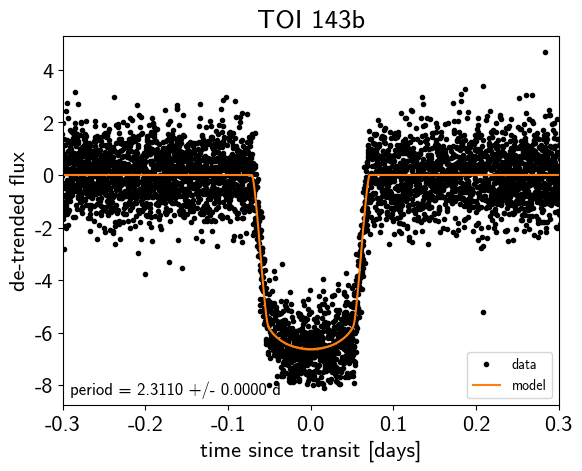

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

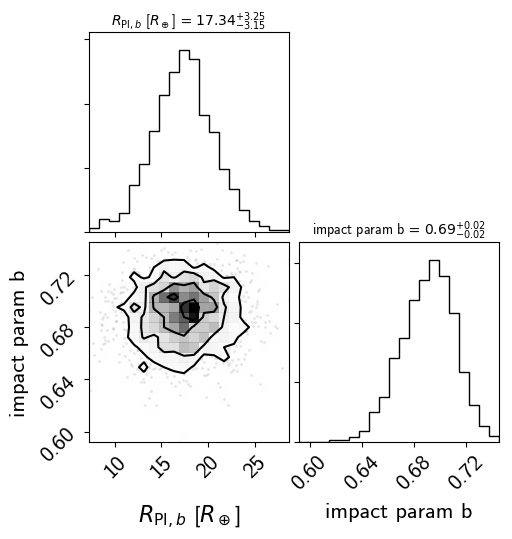

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

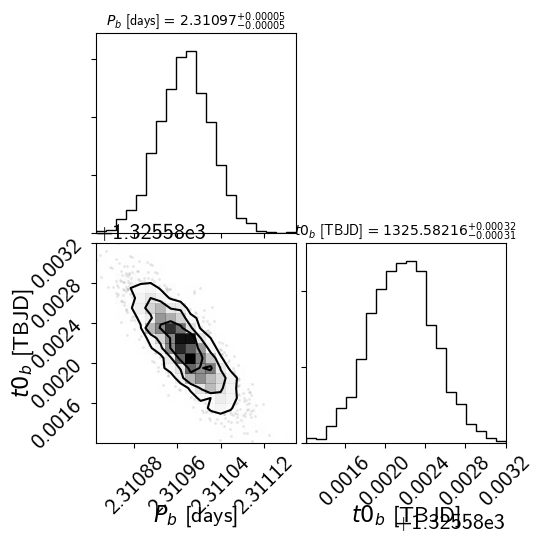

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

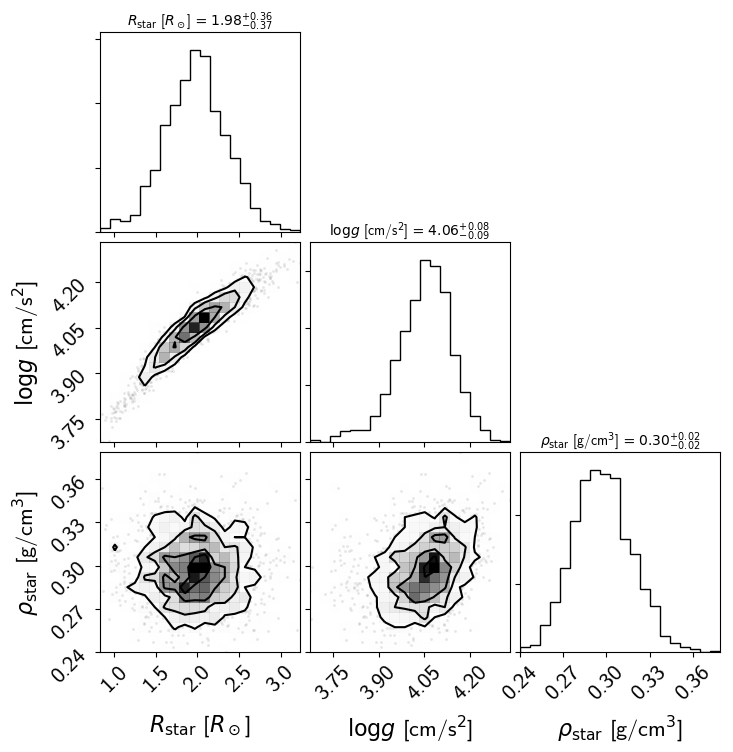

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3